In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [5]:
df = pd.read_csv("data/data.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
print("Shape:", df.shape)
df.info()

Shape: (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [30]:
df.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
TotalRevenue    0
dtype: int64

In [31]:

df = df.dropna(subset=['CustomerID'])
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [13]:

df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']
daily_revenue = df.groupby(df['InvoiceDate'].dt.date)['TotalRevenue'].sum().reset_index()
daily_revenue.columns = ['Date', 'Revenue']
daily_revenue['Date'] = pd.to_datetime(daily_revenue['Date'])
daily_revenue.head()


,Date,Revenue
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-05,31771.60
4,2010-12-06,31215.64


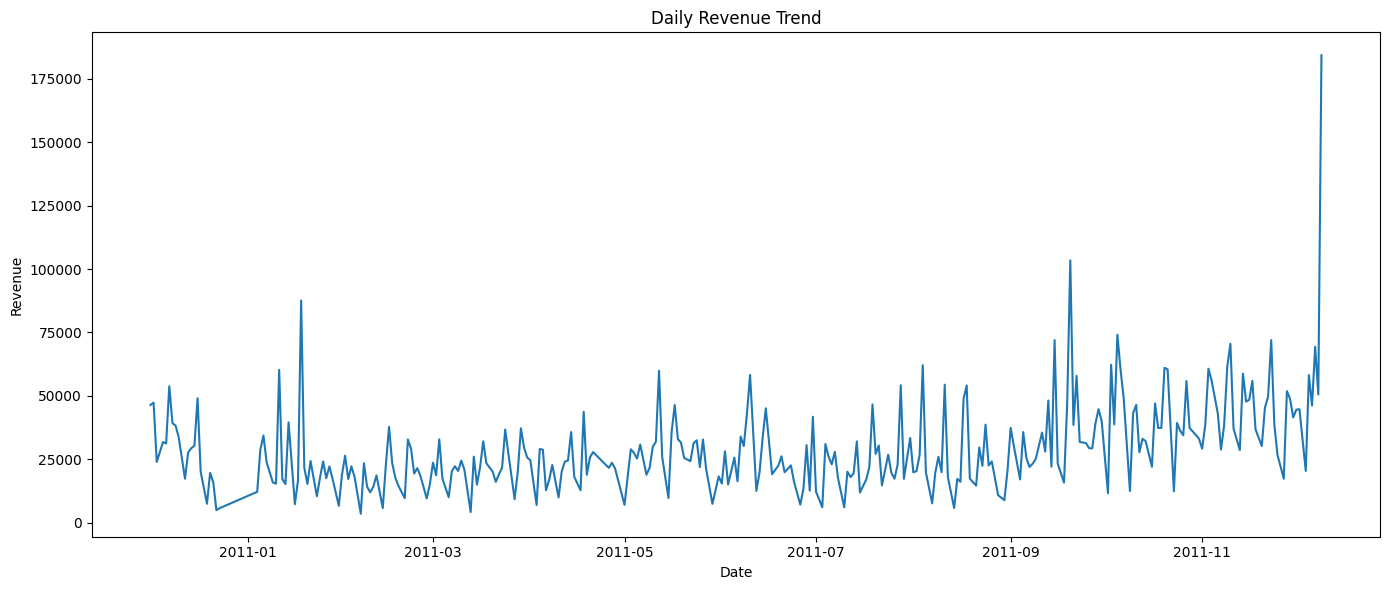

In [15]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_revenue, x='Date', y='Revenue')
plt.title('Daily Revenue Trend')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()


In [16]:
result = adfuller(daily_revenue['Revenue'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -0.3660928783618697
p-value: 0.9156079845685725


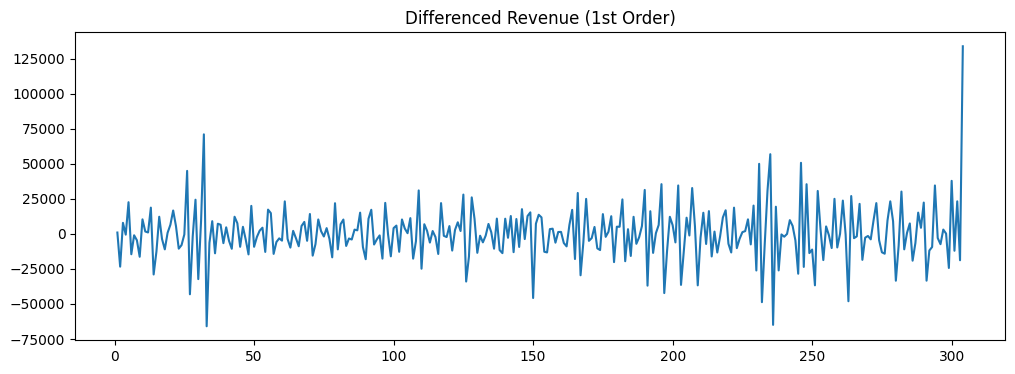

In [17]:
revenue_diff = daily_revenue['Revenue'].diff().dropna()
plt.figure(figsize=(12, 4))
plt.plot(revenue_diff)
plt.title("Differenced Revenue (1st Order)")
plt.show()


In [18]:
model = ARIMA(daily_revenue['Revenue'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  305
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3370.071
Date:                Fri, 23 May 2025   AIC                           6746.141
Time:                        14:13:45   BIC                           6757.292
Sample:                             0   HQIC                          6750.602
                                - 305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0784      0.101      0.773      0.439      -0.120       0.277
ma.L1         -0.9209      0.036    -25.593      0.000      -0.991      -0.850
sigma2      2.769e+08   5.96e-11   4.65e+18      0.0

In [24]:
forecast = model_fit.forecast(steps=7)
print("7-Day Forecast:")
print(forecast)

7-Day Forecast:
305    67478.237753
306    58310.353851
307    57591.184298
308    57534.769442
309    57530.344010
310    57529.996860
311    57529.969628
Name: predicted_mean, dtype: float64


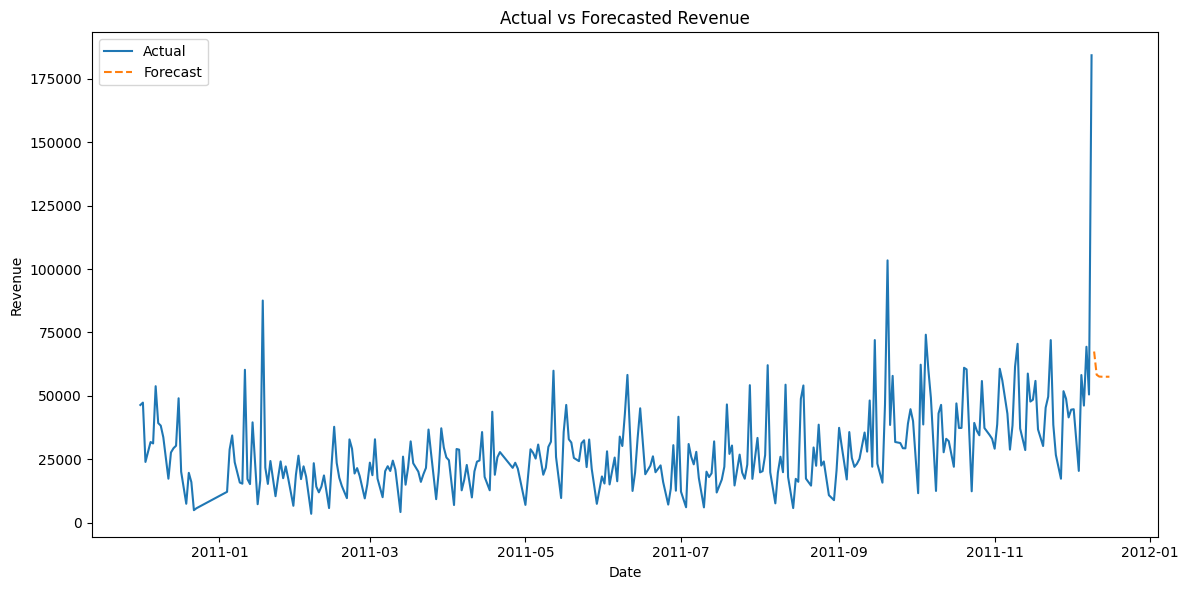

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(daily_revenue['Date'], daily_revenue['Revenue'], label='Actual')
future_dates = pd.date_range(start=daily_revenue['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual vs Forecasted Revenue')
plt.legend()
plt.tight_layout()
plt.show()

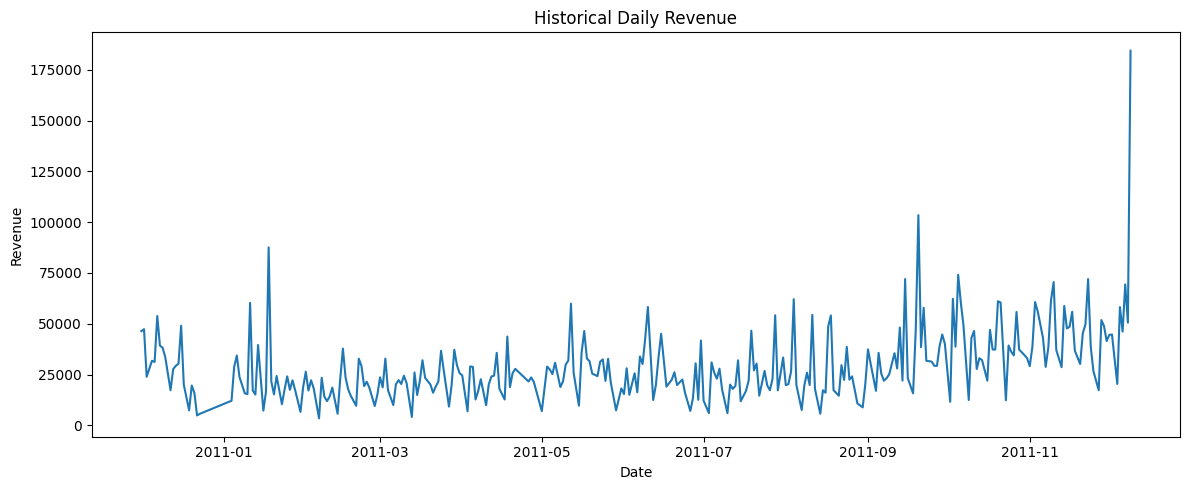

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(daily_revenue['Date'], daily_revenue['Revenue'])
plt.title("Historical Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()